In [1]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier
import tqdm
from scipy.interpolate import griddata
import heapq
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Function to initialize ratings
def initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures):
    ratings = {}
    league_ratings = {}

    # Get the list of competitions
    competitions = set(df_results['Div']).union(set(df_fixtures['Div'])).union(set(df_int_results['HomeDiv'])).union(set(df_int_fixtures['HomeDiv'])).union(set(df_int_results['AwayDiv'])).union(set(df_int_fixtures['AwayDiv']))

    # Iterate over teams in the results data
    teams = set(df_results['HomeTeam']).union(set(df_results['AwayTeam'])).union(set(df_fixtures['HomeTeam'])).union(set(df_fixtures['AwayTeam'])).union(set(df_int_results['HomeTeam'])).union(set(df_int_fixtures['HomeTeam'])).union(set(df_int_results['AwayTeam'])).union(set(df_int_fixtures['AwayTeam']))

    for team in teams:
        ratings[team] = {}

        # Initialize ratings for each team for each competition
        for competition in competitions:
            ratings[team][competition] = {
                'brH': 0.0,
                'brA': 0.0,
                'continuous_overunderperformances': 0
            }
    
    
    for competition in competitions:
        if '1' in competition:  # Check if it's a top tier league
            league_ratings[competition] = {
                'INT1': {
                    'brH': 0.0,
                    'brA': 0.0,
                    'continuous_overunderperformances': 0,
                },
                'DCUP': {
                    'brH': 0.5,
                    'brA': 0.5 * 0.96,
                    'continuous_overunderperformances': 0,
                }
            }
        else:  # Assume it's a second tier league otherwise
            league_ratings[competition] = {
                'INT1': {
                    'brH': 0.0,
                    'brA': 0.0,
                    'continuous_overunderperformances': 0,
                },
                'DCUP': {
                    'brH': -0.5,
                    'brA': -0.5 * 0.96,
                    'continuous_overunderperformances': 0,
                }
            }
            
    #print('Teams:', teams, end='\n\n')
    return ratings, league_ratings


In [3]:
# Function to update ratings based on results data
def update_ratings_multiple_games(df_results, ratings, league_ratings, rates):
    ind_threshold = rates['ind_threshold']
    games_with_rating = []
    training_games = []

    # Iterate over each match in the results data
    for index, row in df_results.iterrows():

        # Identify the competition in which the match took place
        competition = row['Div']

        if index > ind_threshold:
            #add current game to training data
            training_games.append({
                #"brH_x": ratings[row["HomeTeam"]][competition]["brH"],
                #"brA_x": ratings[row["HomeTeam"]][competition]["brA"],
                #"prH_x": calculate_provisional_ratings(ratings, row["HomeTeam"], competition, rates)[0],
                #"prA_x": calculate_provisional_ratings(ratings, row["HomeTeam"], competition, rates)[1],
                #"brH_y": ratings[row["AwayTeam"]][competition]["brH"],
                #"brA_y": ratings[row["AwayTeam"]][competition]["brA"],
                #"prH_y": calculate_provisional_ratings(ratings, row["AwayTeam"], competition, rates)[0],
                #"prA_y": calculate_provisional_ratings(ratings, row["AwayTeam"], competition, rates)[1],
                #"rating_difference": (calculate_provisional_ratings(ratings, row["HomeTeam"], competition, rates)[0]) - (calculate_provisional_ratings(ratings, row["AwayTeam"], competition, rates)[1]),
                "rating_difference": ratings[row["HomeTeam"]][competition]["brH"] - ratings[row["AwayTeam"]][competition]["brA"],
                #"FTHG": row["FTHG"],
                #"FTAG": row["FTAG"],
                "FTR": row["FTR"]
            })

        
        ratings = update_ratings_single_game(row['HomeTeam'], row['AwayTeam'], row['FTHG'], row['FTAG'], ratings, league_ratings, rates, competition)
        
        
        games_with_rating.append({
            "team": row["HomeTeam"],
            "home_rating": ratings[row["HomeTeam"]][competition]["brH"],
            "away_rating": ratings[row["HomeTeam"]][competition]["brA"],
            "continuous_overunderperformances": ratings[row["HomeTeam"]][competition]["continuous_overunderperformances"],
        })

        games_with_rating.append({
            "team": row["AwayTeam"],
            "home_rating": ratings[row["AwayTeam"]][competition]["brH"],
            "away_rating": ratings[row["AwayTeam"]][competition]["brA"],
            "continuous_overunderperformances": ratings[row["AwayTeam"]][competition]["continuous_overunderperformances"],
        })
        

    return ratings, games_with_rating, training_games

In [4]:
def update_league_ratings_multiple_games(df_int_results, league_ratings, rates):
    games_with_rating_league = []
    game_counter = 0
    # Iterate over each match in the international results data
    for index, row in df_int_results.iterrows():
        # Extract relevant information from the row
        HomeLeague = row['HomeDiv']
        AwayLeague = row['AwayDiv']
        Div = row['Div']
        FTHG = row['FTHG']
        FTAG = row['FTAG']

        # Update the league ratings based on the match result
        league_ratings = update_league_ratings_single_game(HomeLeague, AwayLeague, Div, FTHG, FTAG, league_ratings, rates)
        game_counter += 1
        
        if Div == 'INT1':
            games_with_rating_league.append({
                "league": HomeLeague,
                "home_rating": league_ratings[HomeLeague]["INT1"]["brH"],
                "away_rating": league_ratings[HomeLeague]["INT1"]["brA"],
                "game_counter": game_counter, 
            })
        
            games_with_rating_league.append({
                "league": AwayLeague,
                "home_rating": league_ratings[AwayLeague]["INT1"]["brH"],
                "away_rating": league_ratings[AwayLeague]["INT1"]["brA"],
                "game_counter": game_counter,
            })

    return league_ratings, games_with_rating_league


In [5]:
# Function to update ratings based on results data
def update_ratings_single_game(HomeTeam, AwayTeam, FTHG, FTAG, ratings, league_ratings, rates, competition):

    #lambda: Determines to what extent the new match results influence the team ratings (could be improved to include temporal difference between matches)
    #learning_rate_lambda = 0.054
    learning_rate_lambda = rates['lambda']

    #psi: diminish the impact each additional goal difference error has on team ratings
    diminishing_function_psi = lambda error: 3 * np.log10(1 + error)

    #gamma: determines to what extent performances at the home grounds influence away team ratings and vice versa
    #learning_rate_gamma = 0.79
    learning_rate_gamma = rates['gamma']
    

    #print(HomeTeam, "-", AwayTeam, FTHG, ":", FTAG)

    observed_goal_difference = FTHG - FTAG
    #print("Observed Goal Difference:", observed_goal_difference)
    
    
    # improved initialisation of ratings for teams transitioning leagues
    competitions = set(ratings[HomeTeam].keys()).union(set(ratings[AwayTeam].keys()))
    
    alpha = rates['alpha']
    
    if alpha != 99: 
        for team in [HomeTeam, AwayTeam]:
            if ratings[team][competition]['brH'] == 0 and ratings[team][competition]['brA'] == 0 and league_ratings[competition]['DCUP']['brH'] != 0:
                for otherCompetition in competitions:
                    if ratings[team][otherCompetition]['brH'] != 0 or ratings[team][otherCompetition]['brA'] != 0:
                        if '2' in otherCompetition and '1' in competition:  # promotion
                            promoted_teams_ratings[team] = ((ratings[team][otherCompetition]['brH'] + ratings[team][otherCompetition]['brA']) / 2)            
                        elif '1' in otherCompetition and '2' in competition:  # relegation
                            relegated_teams_ratings[team] = ((ratings[team][otherCompetition]['brH'] + ratings[team][otherCompetition]['brA']) / 2)
                        else:
                            print("error at init")
                        #print(league_ratings[otherCompetition]['DCUP']['brH'] - league_ratings[competition]['DCUP']['brH'])
                        ratings[team][competition]['brH'] = ratings[team][otherCompetition]['brH'] + alpha *(league_ratings[otherCompetition]['DCUP']['brH'] - league_ratings[competition]['DCUP']['brH'])
                        ratings[team][competition]['brA'] = ratings[team][otherCompetition]['brA'] + alpha *(league_ratings[otherCompetition]['DCUP']['brA'] - league_ratings[competition]['DCUP']['brA'])
                        break
             
    #Calculate expected goals for home team
    #expected_goal_x = round((10 ** (abs(ratings[HomeTeam]['brH']) / 3)) - 1,5)
    expected_goal_x_temp = abs(ratings[HomeTeam][competition]['brH']) / 3
    expected_goal_x = np.sign(ratings[HomeTeam][competition]['brH']) * (np.power(10, expected_goal_x_temp) - 1)
    #print("Expected Goals x:", expected_goal_x)

    # Calculate expected goals for away team
    #expected_goal_y = round((10 ** (abs(ratings[AwayTeam]['brA']) / 3)) - 1,5)
    expected_goal_y_temp = abs(ratings[AwayTeam][competition]['brA']) / 3
    expected_goal_y = np.sign(ratings[AwayTeam][competition]['brA']) * (np.power(10, expected_goal_y_temp) - 1)
    #print("Expected Goals y:", expected_goal_y)

    # Calculate expected goal difference based on ratings
    expected_goal_difference = expected_goal_x - expected_goal_y
    #print("Expected Goal Difference:", expected_goal_difference)

    # Calculate the error between observed and expected goal difference
    error = abs(observed_goal_difference - expected_goal_difference)
    #print("error:", error)

    psi_temp = diminishing_function_psi(error)

    # Diminish the impact of the goal difference error for both teams x and y respectively
    if (expected_goal_difference < observed_goal_difference):
        diminishing_function_psi_x = psi_temp
        diminishing_function_psi_y = -psi_temp
    else:
        diminishing_function_psi_x = -psi_temp
        diminishing_function_psi_y = psi_temp
    #print("Diminishing Function psi x:", diminishing_function_psi_x)
    #print("Diminishing Function psi y:", diminishing_function_psi_y)

    # Update the home team x background ratings
    previous_home_rating_x = ratings[HomeTeam][competition]['brH']
    previous_away_rating_x = ratings[HomeTeam][competition]['brA']
    #print("Old brH x:", previous_home_rating_x)
    #print("Old brA x:", previous_away_rating_x)
    
        

    ratings[HomeTeam][competition]['brH'] = previous_home_rating_x + diminishing_function_psi_x * learning_rate_lambda
    ratings[HomeTeam][competition]['brA'] = previous_away_rating_x + (ratings[HomeTeam][competition]['brH'] - previous_home_rating_x) * learning_rate_gamma
    #print("New brH x:", ratings[HomeTeam]['brH'])
    #print("New brA x:", ratings[HomeTeam]['brA'])

    # Update the away team y background ratings
    previous_home_rating_y = ratings[AwayTeam][competition]['brH']
    previous_away_rating_y = ratings[AwayTeam][competition]['brA']
    #print("Old brH y:", previous_home_rating_y)
    #print("Old brA y:", previous_away_rating_y)

    ratings[AwayTeam][competition]['brA'] = previous_away_rating_y + diminishing_function_psi_y * learning_rate_lambda
    ratings[AwayTeam][competition]['brH'] = previous_home_rating_y + (ratings[AwayTeam][competition]['brA'] - previous_away_rating_y) * learning_rate_gamma
    #print("New brH y:", ratings[AwayTeam]['brH'])
    #print("New brA y:", ratings[AwayTeam]['brA'])
    
    
    """
    if HomeTeam == 'Liverpool' and AwayTeam == 'Man United' and FTHG == 7:
        print('Observed Goal Difference:', observed_goal_difference)
        print('Expected Goals x:', expected_goal_x)
        print('Expected Goals y:', expected_goal_y)
        print('Expected Goal Difference:', expected_goal_difference)
        print('Error:', error)
        print('Psi:', psi_temp)
        print('Diminishing Function psi x:', diminishing_function_psi_x)
        print('Diminishing Function psi y:', diminishing_function_psi_y)
        print('Old brH x:', previous_home_rating_x)
        print('Old brA x:', previous_away_rating_x)
        print('Old brH y:', previous_home_rating_y)
        print('Old brA y:', previous_away_rating_y)
        print('New brH x:', ratings[HomeTeam][competition]['brH'])
        print('New brA x:', ratings[HomeTeam][competition]['brA'])
        print('New brH y:', ratings[AwayTeam][competition]['brH'])
        print('New brA y:', ratings[AwayTeam][competition]['brA'])
    """
    #print("Old overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("Old overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'])

    # Update the continuous over/underperformances for the home team
    if (observed_goal_difference > expected_goal_difference):
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = max(1, ratings[HomeTeam][competition]['continuous_overunderperformances'] + 1)
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = min(-1, ratings[AwayTeam][competition]['continuous_overunderperformances'] - 1)
    elif (observed_goal_difference < expected_goal_difference):
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = min(-1, ratings[HomeTeam][competition]['continuous_overunderperformances'] - 1)
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = max(1, ratings[AwayTeam][competition]['continuous_overunderperformances'] + 1)
    else:
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = 0
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = 0

    #print("New overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("New overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'], end='\n\n')

    return ratings


In [6]:
# Function to update ratings based on results data
def update_league_ratings_single_game(HomeLeague, AwayLeague, Div, FTHG, FTAG, league_ratings, rates):

    #lambda: Determines to what extent the new match results influence the team ratings (could be improved to include temporal difference between matches)
    #learning_rate_lambda = 0.054
    learning_rate_lambda = rates['lambda2']

    #psi: diminish the impact each additional goal difference error has on team ratings
    diminishing_function_psi = lambda error: 3 * np.log10(1 + error)

    #gamma: determines to what extent performances at the home grounds influence away team ratings and vice versa
    #learning_rate_gamma = 0.79
    learning_rate_gamma = rates['gamma2']

    #print(HomeTeam, "-", AwayTeam, FTHG, ":", FTAG)


    observed_goal_difference = FTHG - FTAG
    #print("Observed Goal Difference:", observed_goal_difference)

    #Calculate expected goals for home team
    #expected_goal_x = round((10 ** (abs(ratings[HomeTeam]['brH']) / 3)) - 1,5)
    expected_goal_x_temp = abs(league_ratings[HomeLeague][Div]['brH']) / 3
    expected_goal_x = np.sign(league_ratings[HomeLeague][Div]['brH']) * (np.power(10, expected_goal_x_temp) - 1)
    #print("Expected Goals x:", expected_goal_x)

    # Calculate expected goals for away team
    #expected_goal_y = round((10 ** (abs(ratings[AwayTeam]['brA']) / 3)) - 1,5)
    expected_goal_y_temp = abs(league_ratings[AwayLeague][Div]['brA']) / 3
    expected_goal_y = np.sign(league_ratings[AwayLeague][Div]['brA']) * (np.power(10, expected_goal_y_temp) - 1)
    #print("Expected Goals y:", expected_goal_y)

    # Calculate expected goal difference based on ratings
    expected_goal_difference = expected_goal_x - expected_goal_y
    #print("Expected Goal Difference:", expected_goal_difference)

    # Calculate the error between observed and expected goal difference
    error = abs(observed_goal_difference - expected_goal_difference)
    #print("error:", error)

    psi_temp = diminishing_function_psi(error)

    # Diminish the impact of the goal difference error for both teams x and y respectively
    if (expected_goal_difference < observed_goal_difference):
        diminishing_function_psi_x = psi_temp
        diminishing_function_psi_y = -psi_temp
    else:
        diminishing_function_psi_x = -psi_temp
        diminishing_function_psi_y = psi_temp
    #print("Diminishing Function psi x:", diminishing_function_psi_x)
    #print("Diminishing Function psi y:", diminishing_function_psi_y)

    # Update the home team x background ratings
    previous_home_rating_x = league_ratings[HomeLeague][Div]['brH']
    previous_away_rating_x = league_ratings[HomeLeague][Div]['brA']
    #print("Old brH x:", previous_home_rating_x)
    #print("Old brA x:", previous_away_rating_x)

    league_ratings[HomeLeague][Div]['brH'] = previous_home_rating_x + diminishing_function_psi_x * learning_rate_lambda
    league_ratings[HomeLeague][Div]['brA'] = previous_away_rating_x + (league_ratings[HomeLeague][Div]['brH'] - previous_home_rating_x) * learning_rate_gamma
    #print("New brH x:", ratings[HomeTeam]['brH'])
    #print("New brA x:", ratings[HomeTeam]['brA'])

    # Update the away team y background ratings
    previous_home_rating_y = league_ratings[AwayLeague][Div]['brH']
    previous_away_rating_y = league_ratings[AwayLeague][Div]['brA']
    #print("Old brH y:", previous_home_rating_y)
    #print("Old brA y:", previous_away_rating_y)

    league_ratings[AwayLeague][Div]['brA'] = previous_away_rating_y + diminishing_function_psi_y * learning_rate_lambda
    league_ratings[AwayLeague][Div]['brH'] = previous_home_rating_y + (league_ratings[AwayLeague][Div]['brA'] - previous_away_rating_y) * learning_rate_gamma
    #print("New brH y:", ratings[AwayTeam]['brH'])
    #print("New brA y:", ratings[AwayTeam]['brA'])

    #print("Old overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("Old overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'])

    # Update the continuous over/underperformances for the home team
    if (observed_goal_difference > expected_goal_difference):
        league_ratings[HomeLeague][Div]['continuous_overunderperformances'] = max(1, league_ratings[HomeLeague][Div]['continuous_overunderperformances'] + 1)
        league_ratings[AwayLeague][Div]['continuous_overunderperformances'] = min(-1, league_ratings[AwayLeague][Div]['continuous_overunderperformances'] - 1)
    elif (observed_goal_difference < expected_goal_difference):
        league_ratings[HomeLeague][Div]['continuous_overunderperformances'] = min(-1, league_ratings[HomeLeague][Div]['continuous_overunderperformances'] - 1)
        league_ratings[AwayLeague][Div]['continuous_overunderperformances'] = max(1, league_ratings[AwayLeague][Div]['continuous_overunderperformances'] + 1)
    else:
        league_ratings[HomeLeague][Div]['continuous_overunderperformances'] = 0
        league_ratings[AwayLeague][Div]['continuous_overunderperformances'] = 0

    #print("New overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("New overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'], end='\n\n')

    return league_ratings


In [7]:
def calculate_provisional_ratings(ratings, team, competition, rates):

    #phi: Represents the number of continuous performances, above or below expectations, which do not trigger the form factor
    #form_threshold_phi = 1
    form_threshold_phi = rates['phi']

    #mu: represents the rating difference used to establish provisional ratings from background ratings
    #rating_impact_mu = 0.01
    rating_impact_mu = rates['mu']

    #delta: the level by which rating impact μ diminishes with each additional continuous over/under-performance
    #diminishing_factor_delta = 2.5
    diminishing_factor_delta = rates['delta']

    brH = ratings[team][competition]['brH']  # Background rating home
    brA = ratings[team][competition]['brA']  # Background rating away

    return brH, brA
    
    
    phi_current = abs(ratings[team][competition]['continuous_overunderperformances'])
    
    if abs(phi_current) < (form_threshold_phi + 1):
        return brH, brA
    
    """
    prH = brH
    prA = brA
    
    phi_diff = int(abs(phi_current) - form_threshold_phi)
    #print("phi_diff:", phi_diff)
    for i in range(phi_diff):
        # Calculate performance factor for home team x
        a = phi_diff - i
        b = a ** diminishing_factor_delta
        form_factor_home = a / b
        
        prH += np.sign(phi_current) * rating_impact_mu * form_factor_home
        prA += np.sign(phi_current) * rating_impact_mu * form_factor_home
    """
    
    # Calculate performance factor for home team x
    a = abs(phi_current) - form_threshold_phi
    b = a ** diminishing_factor_delta
    form_factor_home = a / b

    # Calculate provisional rating of the team
    if (phi_current > form_threshold_phi):
        prH = brH + rating_impact_mu * form_factor_home
        prA = brA + rating_impact_mu * form_factor_home
    elif (phi_current < -form_threshold_phi):
        prH = brH - rating_impact_mu * form_factor_home
        prA = brA - rating_impact_mu * form_factor_home
    else:
        prH = brH
        prA = brA
    
        
    return prH, prA

In [8]:
def calculate_probabilities(features, model):

    new_game_rating_difference = np.array([features])
    probabilities = model.predict_proba(new_game_rating_difference)
    return probabilities[0]

In [9]:
# Function to calculate the rating difference between two teams
def calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings, league_ratings, HomeLeague, Awayleague, rates):
    rho = rates['rho']
    sigma = rates['sigma']
    
    competition1 = competition
    competition2 = competition
    if competition == 'INT1':
        competition1 = HomeLeague
        competition2 = Awayleague
        
    # Calculate provisional ratings if necessary
    home_rating_x = ratings[HomeTeam][competition1]['brH']
    away_rating_y = ratings[AwayTeam][competition2]['brA']
    if (abs(ratings[HomeTeam][competition1]['continuous_overunderperformances']) > 1):
        provisional_ratings_x = calculate_provisional_ratings(ratings, HomeTeam, competition1, rates)
        home_rating_x = provisional_ratings_x[0]
    if (abs(ratings[AwayTeam][competition2]['continuous_overunderperformances']) > 1):
        provisional_ratings_y = calculate_provisional_ratings(ratings, AwayTeam, competition2, rates)
        away_rating_y = provisional_ratings_y[1]
    
    if competition == 'INT1':
        """
        if HomeTeam == 'Man City' and AwayTeam == 'Inter':
            print('Prior home rating x:', home_rating_x)
            print('Prior away rating y:', away_rating_y)
            print('Home league rating x:', league_ratings[competition1]['INT1']['brH'])
            print('Away league rating y:', league_ratings[competition2]['INT1']['brA'])
        """
        home_rating_x = rho * home_rating_x + sigma * league_ratings[competition1]['INT1']['brH']
        away_rating_y = rho * away_rating_y + sigma * league_ratings[competition2]['INT1']['brA']

    # Calculate rating difference
    rating_difference = home_rating_x - away_rating_y
    """
    if HomeTeam == 'Man City' and AwayTeam == 'Inter':
            print('Int home rating x:', home_rating_x)
            print('Int away rating y:', away_rating_y)
            print('Rating difference:', rating_difference, end='\n\n')
    """
    return rating_difference

In [10]:
def predict_outcomes(df_fixtures, ratings, league_ratings, rates, model):
    
    all_rps = []
    league_ratings_fake = {}
    HomeLeague = 'fake'
    Awayleague = 'fake'
    
    # Store comparisons between model's probabilities and bookmakers
    comparisons = []

    for index, row in df_fixtures.iterrows():
        HomeTeam = row['HomeTeam']
        AwayTeam = row['AwayTeam']
        competition = row['Div']
        
        # Check if odds are available and are numeric
        try:
            P_Home = 1 / float(row['B365H'])
            P_Draw = 1 / float(row['B365D'])
            P_Away = 1 / float(row['B365A'])
            Total_P = P_Home + P_Draw + P_Away
            P_Home_norm = P_Home / Total_P
            P_Draw_norm = P_Draw / Total_P
            P_Away_norm = P_Away / Total_P
        except:
            P_Home_norm = None
            P_Draw_norm = None
            P_Away_norm = None
        
        """
        if index == 4039:
            print('Home Team: ', HomeTeam)
            print('Away Team: ', AwayTeam)
            print('Prior home rating x: ', ratings[HomeTeam][competition]['brH'])
            print('Prior away rating x: ', ratings[HomeTeam][competition]['brA'])
            #print('Prior continous over- / underperformance x: ', ratings[HomeTeam][HomeLeague]['continuous_overunderperformances'])
            print('Prior home rating y: ', ratings[AwayTeam][competition]['brH'])
            print('Prior away rating y: ', ratings[AwayTeam][competition]['brA'])
            #print('Prior continous over- / underperformance y: ', ratings[AwayTeam][AwayLeague]['continuous_overunderperformances'])
        """
        """
        # Initialize league table for the competition if it doesn't exist
        if competition not in league_tables:
            league_tables[competition] = pd.DataFrame(columns=['team', 'games_played', 'points'])
        """
        
        rating_difference = calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings, league_ratings_fake, HomeLeague, Awayleague, rates)
        

        #features = [prH_x, prA_x, prH_y, prA_y]
        features = [rating_difference]

        away_win_prob, draw_prob, home_win_prob = calculate_probabilities(features, model)
        
        # Only add to comparisons if odds were available and valid
        if P_Home_norm and P_Draw_norm and P_Away_norm:
            comparison_data = {
                'Div': competition,
                'Date': row['Date'], 
                'HomeTeam': HomeTeam,
                'AwayTeam': AwayTeam,
                'Predicted_Home': home_win_prob,
                'Bookmaker_Home': P_Home_norm,
                'Predicted_Draw': draw_prob,
                'Bookmaker_Draw': P_Draw_norm,
                'Predicted_Away': away_win_prob,
                'Bookmaker_Away': P_Away_norm
            }
            comparisons.append(comparison_data)


        """
        FTHG = int(row['FTHG'])
        FTAG = int(row['FTAG'])

        print(f"{HomeTeam} - {AwayTeam} {FTHG}:{FTAG}")
        print(f"Home Win Prob: {home_win_prob}")
        print(f"Draw Prob: {draw_prob}")
        print(f"Away Win Prob: {away_win_prob}", end='\n\n')
        """


        # Call Ranked Probability Score function
        probs = [home_win_prob, draw_prob, away_win_prob]
        if row["FTR"] == "H":
            outcome = [1, 0, 0]
        elif row["FTR"] == "D":
            outcome = [0, 1, 0]
        else:
            outcome = [0, 0, 1]

        rps_score = rps(probs, outcome)
        #print("RPS Score:", rps_score, end='\n\n')
        all_rps.append(rps_score)
        

        # Update league table
       #league_tables[competition] = update_league_table(league_tables[competition], HomeTeam, AwayTeam, home_win_prob, draw_prob, away_win_prob)
        
        # Update ratings
        ratings = update_ratings_single_game(HomeTeam, AwayTeam, row['FTHG'], row['FTAG'], ratings, league_ratings, rates, competition)
        """
        if index == 4039:
            
            print('Rating Difference: ', rating_difference)
            print('Home Win Prob: ', home_win_prob)
            print('Draw Prob: ', draw_prob)
            print('Away Win Prob: ', away_win_prob)
            print('RPS Score: ', rps_score)
        """
    print(f"Average RPS Score for {competition}:", np.mean(all_rps), '\n')
    
    """
    # Sort all league tables
    for competition, table in league_tables.items():
        assert isinstance(table, pd.DataFrame), f"Unexpected object: {type(table)} for competition: {competition}"
        table = table.sort_values(['points', 'games_played'], ascending=False)
        table = table.reset_index(drop=True)
        league_tables[competition] = table
    """
    
    return all_rps, league_tables, comparisons


In [11]:
def predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model):

    int_rps = []
    
    for index, row in df_int_fixtures.iterrows():
        HomeTeam = row['HomeTeam']
        AwayTeam = row['AwayTeam']
        HomeLeague = row['HomeDiv']
        AwayLeague = row['AwayDiv']

        competition = row['Div']
        """
        if index == 124:
            print('Home Team: ', HomeTeam)
            print('Away Team: ', AwayTeam)
            print('Home League: ', HomeLeague)
            print('Away League: ', AwayLeague)
            print('Prior home rating x: ', ratings[HomeTeam][HomeLeague]['brH'])
            print('Prior away rating x: ', ratings[HomeTeam][HomeLeague]['brA'])
            #print('Prior continous over- / underperformance x: ', ratings[HomeTeam][HomeLeague]['continuous_overunderperformances'])
            print('Prior home rating y: ', ratings[AwayTeam][AwayLeague]['brH'])
            print('Prior away rating y: ', ratings[AwayTeam][AwayLeague]['brA'])
            #print('Prior continous over- / underperformance y: ', ratings[AwayTeam][AwayLeague]['continuous_overunderperformances'])
            print('Prior home league rating x: ', league_ratings[HomeLeague]['INT1']['brH'])
            print('Prior away league rating x: ', league_ratings[HomeLeague]['INT1']['brA'])
            #print('Prior continous over- / underperformance league of x: ', league_ratings[HomeLeague]['INT1']['continuous_overunderperformances'])
            print('Prior home league rating y: ', league_ratings[AwayLeague]['INT1']['brH'])
            print('Prior away league rating y: ', league_ratings[AwayLeague]['INT1']['brA'])
            #print('Prior continous over- / underperformance league of y: ', league_ratings[AwayLeague]['INT1']['continuous_overunderperformances'])
        """
        
        rating_difference = calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings, league_ratings, HomeLeague, AwayLeague, rates)
        
            
            

        #features = [prH_x, prA_x, prH_y, prA_y]
        features = [rating_difference]

        away_win_prob, draw_prob, home_win_prob = calculate_probabilities(features, model)


        """
        FTHG = int(row['FTHG'])
        FTAG = int(row['FTAG'])



        print(f"{HomeTeam} - {AwayTeam} {FTHG}:{FTAG}")
        print(f"Home Win Prob: {home_win_prob}")
        print(f"Draw Prob: {draw_prob}")
        print(f"Away Win Prob: {away_win_prob}", end='\n')
        """
        

        # Call Ranked Probability Score function
        probs = [home_win_prob, draw_prob, away_win_prob]
        if row["FTR"] == "H":
            outcome = [1, 0, 0]
        elif row["FTR"] == "D":
            outcome = [0, 1, 0]
        else:
            outcome = [0, 0, 1]

        rps_score = rps(probs, outcome)
        #print("RPS Score:", rps_score, end='\n\n')
        int_rps.append(rps_score)
        
        """
        if index == 124:
            
            print('Rating Difference: ', rating_difference)
            print('Home Win Prob: ', home_win_prob)
            print('Draw Prob: ', draw_prob)
            print('Away Win Prob: ', away_win_prob)
            print('RPS Score: ', rps_score)
        """

        # Update league_ratings
        league_ratings = update_league_ratings_single_game(HomeLeague, AwayLeague, competition, row['FTHG'], row['FTAG'], league_ratings, rates)

    print(f"RPS for {competition}:", np.mean(int_rps), '\n')


    return int_rps

In [12]:
def rps(probs, outcome):
    cum_probs = np.cumsum(probs)
    cum_outcomes = np.cumsum(outcome)
    
    sum_rps = (cum_probs[0] - cum_outcomes[0])**2 + (cum_probs[1] - cum_outcomes[1])**2

    return sum_rps/2

In [13]:

from sklearn.ensemble import GradientBoostingClassifier


def train_model(df_train):

    # Create Logistic Regression model
    #model = GradientBoostingClassifier(n_estimators=100)
    model = LogisticRegression(solver="saga", penalty="l2")  
    #model = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(5, 2), max_iter=1000, random_state=23)

    # Reshape rating_difference to 2D array for model fitting
    #X = df_train[['prH_x', 'prA_x', "prH_y", "prA_y"]].values
    X = df_train["rating_difference"].values.reshape(-1, 1)
    y = df_train['FTR']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0001)

    # Fit the model with the training data
    model.fit(X_train, y_train)

    # Save the model and label encoder here
    joblib.dump(model, '../Models/model.pkl')

    # Evaluate the model on the test set
    #score = model.score(X_test, y_test)
    #print(f'Model accuracy: {score*100:.2f}%')

    return model

;

''

In [23]:
# Main Function

# Load the results data file for seasons 2010-2011 to 2021-2022
df_results = pd.read_csv('final_data/new_season_2016-2022_sorted_compressed_top2.csv')

# Load the fixtures data file for the season 2022-2023
df_fixtures = pd.read_csv('final_data/new_season_2022-2023_sorted_top2.csv')

# Load the international results data file
df_int_results = pd.read_csv('final_data/new_season_2016-2022_INT.csv')

# Load the international fixtures data file
df_int_fixtures = pd.read_csv('final_data/new_season_2022-2023_INT.csv')

# Load the domestic cup results data file
df_dcup_results = pd.read_csv('final_data/cleaned_new_season_2016-2022_DCUP.csv')

# Define the learning rates
rates = {
    'lambda': 0.042,
    'gamma': 0.97,
    'delta': 2.5,
    'phi': 1,
    'mu': 0.0,
    'rho': 0.86,
    'sigma': 0.69,
    'alpha': 1.3,
    'ind_threshold': 6000,
    'lambda2': 0.13,
    'gamma2': 0.96,
}

# Map teams to leagues
df_int = pd.concat([df_int_results, df_int_fixtures], ignore_index=True)
#team_to_league, rest_teams = create_team_to_league_mapping(df_results, df_fixtures, df_int)

# Initialize ratings based on the results data
ratings, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)



promoted_teams_ratings = {}
relegated_teams_ratings = {}

# Update ratings based on the results data here
ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)
#model.C_

# Train the model for predicting match outcomes
df_train = pd.DataFrame(training_games)
df_train.to_csv("../data/train232.csv", index=False)
model = train_model(df_train)



"""
# Create a reverse mapping of leagues to teams
league_to_teams = {}
for team, league in team_to_league.items():
    if league not in league_to_teams:
        league_to_teams[league] = []
    league_to_teams[league].append(team)

# Print the teams sorted by league
for league, teams in sorted(league_to_teams.items()):
    print(f"{league}:")
    print(", ".join(teams))
    print()
"""

# Update league ratings based on the results data here
league_ratings, games_with_ratings_league = update_league_ratings_multiple_games(df_int_results, league_ratings, rates)
league_ratings, _ = update_league_ratings_multiple_games(df_dcup_results, league_ratings, rates)

for league, values in league_ratings.items():
    if values['INT1']['brH'] == 0:
        continue
    # International rating
    #print(f"League: {league} (International), Rating: {(values['INT1']['brH'] + values['INT1']['brA']) / 2}")
    
for league, values in league_ratings.items():
    if values['DCUP']['brH'] == 0:
        continue
    # National rating
    #print(f"League: {league} (National), Rating: {(values['DCUP']['brH'] + values['DCUP']['brA']) / 2}")


# Initialize an empty league tables dictionary and rps list
league_tables = {}
all_rps = []

# Initialize variables to keep track of the RPS for each competition
competition_avg_rps = {}
all_comparisons = []

# Predict the probabilities of home win, draw and away win for the fixtures data
for competition in df_fixtures['Div'].unique():
    competition_fixtures = df_fixtures[df_fixtures['Div'] == competition]
    competition_rps, league_tables, competition_comparisons = predict_outcomes(competition_fixtures, ratings, league_ratings, rates, model)
    all_rps.extend(competition_rps)  
    competition_avg_rps[competition] = np.mean(competition_rps)
    all_comparisons.extend(competition_comparisons)

# Compute the average RPS for all leagues
average_rps = np.mean(all_rps)
competition_avg_rps['Overall Average'] = average_rps

# Compute the average RPS for top leagues
top_leagues_rps = [avg_rps for competition, avg_rps in competition_avg_rps.items() if '1' in competition]
average_top_leagues_rps = np.mean(top_leagues_rps)
competition_avg_rps['Average Top Leagues'] = average_top_leagues_rps

# Compute the average RPS for second tier leagues
second_tier_leagues_rps = [avg_rps for competition, avg_rps in competition_avg_rps.items() if '2' in competition]
average_second_tier_leagues_rps = np.mean(second_tier_leagues_rps)
competition_avg_rps['Average Second Tier Leagues'] = average_second_tier_leagues_rps

# Now you can calculate the mean RPS across all competitions
mean_rps = np.mean(all_rps)
print("Average RPS Score across all competitions:", mean_rps)

"""
print("Promoted teams and their average ratings:")
for team, rating in promoted_teams_ratings.items():
    print(f"{team}: {rating}")

print("\nRelegated teams and their average ratings:")
for team, rating in relegated_teams_ratings.items():
    print(f"{team}: {rating}")

print('Average Rating of promoted teams:', np.mean(list(promoted_teams_ratings.values())))
print('Average Rating of relegated teams:', np.mean(list(relegated_teams_ratings.values())))
"""

int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)
competition_avg_rps['International Games'] = np.mean(int_rps)
"""
# print the ratings of each league in DCUP
for league, values in league_ratings.items():
    if values['DCUP']['brH'] == 0:
        continue
    print(f"League: {league} (National), Rating: {(values['DCUP']['brH'] + values['DCUP']['brA']) / 2}")
"""

#combine int_rps and all_rps to one list
combine_rps = all_rps + int_rps

mean_combine_rps = np.mean(combine_rps)
print('Final average RPS Score:', mean_combine_rps)


;

Average RPS Score for DEU2: 0.21983860101218516 

Average RPS Score for BEL1: 0.20445095475954408 

Average RPS Score for ENG2: 0.2239296164501426 

Average RPS Score for SCO1: 0.18794337301119338 
Average RPS Score for FRA2: 0.21783913379604825 

Average RPS Score for SCO2: 0.2237709927706603 

Average RPS Score for NLD1: 0.18376215744084962 

Average RPS Score for TUR1: 0.2034308208546031 

Average RPS Score for DEU1: 0.20603052761523027 

Average RPS Score for ENG1: 0.205108101869341 
Average RPS Score for FRA1: 0.20233617547899904 

Average RPS Score for PRT1: 0.18851241489967585 

Average RPS Score for ITA2: 0.21691705915822887 
Average RPS Score for ESP1: 0.2075529449668767 

Average RPS Score for ESP2: 0.20556678728559138 

Average RPS Score for ITA1: 0.19731604073895675 

Average RPS Score for GRC1: 0.1792926569768045 

Average RPS Score across all competitions: 0.20553534645801236
RPS for INT1: 0.1893665213763417 

Final average RPS Score: 0.20519497880304285


''

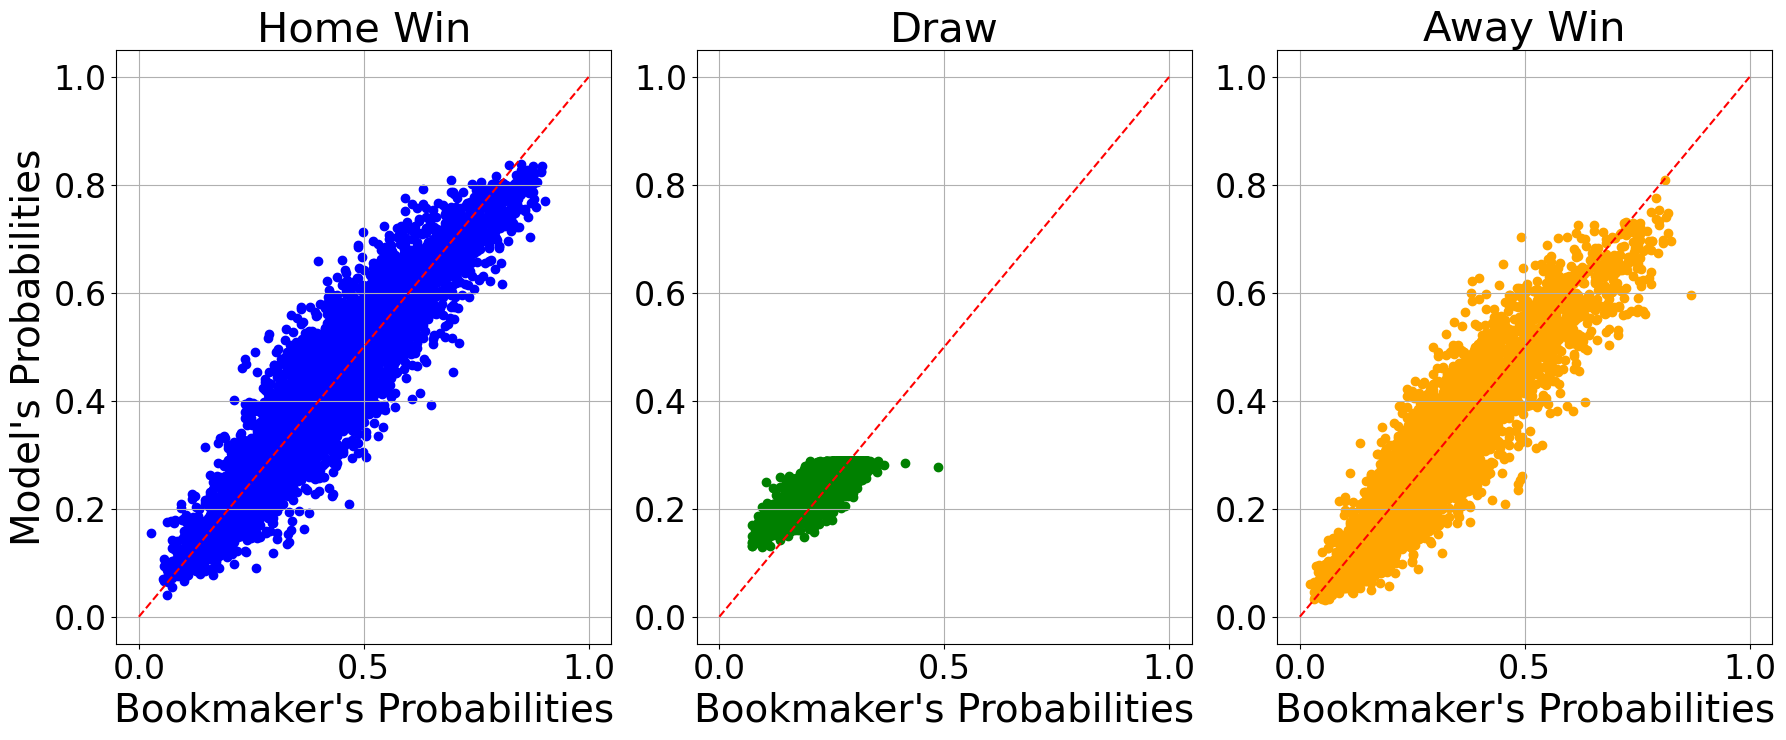

(0.05000790624693375, 0.019875508102723413, 0.04544448878408152)

In [15]:
# code to compare bookmaker odds with predicted probabilities including graphical representation

df_comparisons = pd.DataFrame(all_comparisons)
df_cleaned_comparisons = df_comparisons.dropna(subset=["Bookmaker_Home", "Bookmaker_Draw", "Bookmaker_Away"])
df_cleaned_comparisons.to_csv('../data/comparisons.csv', index=False)
cleaned_comparisons = df_cleaned_comparisons.to_dict(orient="records")

# For demonstration purposes, showing the shape before and after cleaning
df_comparisons.shape, df_cleaned_comparisons.shape

def analyze_comparisons(comparisons):
    # Extract data
    predicted_home_probs = [x['Predicted_Home'] for x in comparisons]
    bookmaker_home_probs = [x['Bookmaker_Home'] for x in comparisons]
    
    predicted_draw_probs = [x['Predicted_Draw'] for x in comparisons]
    bookmaker_draw_probs = [x['Bookmaker_Draw'] for x in comparisons]
    
    predicted_away_probs = [x['Predicted_Away'] for x in comparisons]
    bookmaker_away_probs = [x['Bookmaker_Away'] for x in comparisons]

    # Calculate MAE for each outcome
    mae_home = np.mean(np.abs(np.array(predicted_home_probs) - np.array(bookmaker_home_probs)))
    mae_draw = np.mean(np.abs(np.array(predicted_draw_probs) - np.array(bookmaker_draw_probs)))
    mae_away = np.mean(np.abs(np.array(predicted_away_probs) - np.array(bookmaker_away_probs)))

    # Visualization
    fig, ax = plt.subplots(1, 3, figsize=(18, 7.5))

    # Scatter plot for Home Win
    ax[0].scatter(bookmaker_home_probs, predicted_home_probs, color='blue')
    ax[0].plot([0, 1], [0, 1], color='red', linestyle='--')  
    ax[0].set_xlabel("Bookmaker's Probabilities", fontsize=28)
    ax[0].set_ylabel("Model's Probabilities", fontsize=28)
    ax[0].set_title("Home Win", fontsize=30)
    ax[0].tick_params(axis='both', which='major', labelsize=24)
    ax[0].grid(True)
    
    # Scatter plot for Draw
    ax[1].scatter(bookmaker_draw_probs, predicted_draw_probs, color='green')
    ax[1].plot([0, 1], [0, 1], color='red', linestyle='--')  
    ax[1].set_xlabel("Bookmaker's Probabilities", fontsize=28)
    ax[1].set_title("Draw", fontsize=30)
    ax[1].tick_params(axis='both', which='major', labelsize=24)
    ax[1].grid(True)
    
    # Scatter plot for Away Win
    ax[2].scatter(bookmaker_away_probs, predicted_away_probs, color='orange')
    ax[2].plot([0, 1], [0, 1], color='red', linestyle='--')  
    ax[2].set_xlabel("Bookmaker's Probabilities", fontsize=28)
    ax[2].set_title("Away Win", fontsize=30)
    ax[2].tick_params(axis='both', which='major', labelsize=24)
    ax[2].grid(True)
    
    plt.tight_layout()
    plt.savefig('../images/comparisons.png', dpi=300)
    plt.show()

    return mae_home, mae_draw, mae_away

mae_home, mae_draw, mae_away = analyze_comparisons(cleaned_comparisons)
mae_home, mae_draw, mae_away


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


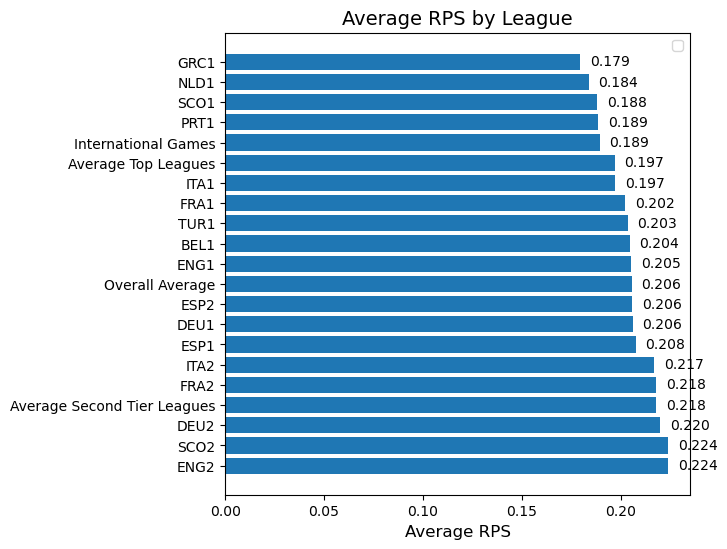

In [16]:
# plot the average RPS score for each league

# Sort the competition_avg_rps dictionary by its values
sorted_competition_avg_rps = {k: v for k, v in sorted(competition_avg_rps.items(), key=lambda item: item[1])}

# Create a DataFrame from the sorted_competition_avg_rps dictionary
df_rps = pd.DataFrame(list(sorted_competition_avg_rps.items()), columns=['League', 'Average RPS'])

# Set the figure size
fig, ax = plt.subplots(figsize=(6, 6))

# Create a bar chart
bars = ax.barh(df_rps['League'], df_rps['Average RPS'])

# Add the RPS values after the bars
for i in range(len(bars)):
    plt.text(bars[i].get_width() + 0.005, bars[i].get_y() + bars[i].get_height()/2,
             f'{bars[i].get_width():.3f}', va='center', color='black', fontsize=10)

# Invert the y-axis
ax.invert_yaxis()

# Set the labels for the x and y axes
ax.set_xlabel('Average RPS', fontsize=12)
#ax.set_ylabel('League', fontsize=12)

# Set the title of the chart
ax.set_title('Average RPS by League', fontsize=14)

# Add a legend
plt.legend()

# Save the figure as a PNG file
plt.savefig('../images/average_rps_by_league.png', bbox_inches='tight')

# Show the figure
plt.show()




In [ ]:
# Gridsearch on alpha

# Define the learning rates
rates = {
    'lambda': 0.043,
    'gamma': 0.98,
    'delta': 2.5,
    'phi': 1,
    'mu': 0.0,
    'rho': 0.86,
    'sigma': 0.7,
    'alpha': 1.3,
    'ind_threshold': 6000,
    'lambda2': 0.13,
    'gamma2': 0.96,
}


# Define a parameter grid with the ranges for your parameters
param_grid = {
    'alpha': np.linspace(0, 2, 21),  
}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable
best_score = float('inf')  # assuming lower scores are better

# Create an empty list to store the results
gs_results_alpha = []

# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    # Update the rates dictionary
    rates.update(params)
    
    ratings, league_ratings = initialize_ratings(df_results, df_fixtures,df_int_results, df_int_fixtures)
    
    # Re-train model with the new parameters
    ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)

    df_train = pd.DataFrame(training_games)
    #df_train.to_csv("../data/train232.csv", index=False)
    model = train_model(df_train)
    
    all_rps = []
    
    for competition in df_fixtures['Div'].unique():
        competition_fixtures = df_fixtures[df_fixtures['Div'] == competition]
        competition_rps, league_tables = predict_outcomes(competition_fixtures, ratings, league_ratings, rates, model)
        all_rps.extend(competition_rps)  # extend the list with rps scores from the current competition

    # Now you can calculate the mean RPS across all competitions
    mean_rps = np.mean(all_rps)

    score = mean_rps
    

    # Store the current results
    gs_results_alpha.append({
        'alpha': rates['alpha'],
        'score': score,
    })
    
    print(f"alpha: {rates['alpha']}, Score: {score}")

In [ ]:
# plot the results of the gridsearch on alpha

# Extract the alpha values and the corresponding scores from the results
alphas = [result['alpha'] for result in gs_results_alpha]
scores = [result['score'] for result in gs_results_alpha]

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the scores as a function of alpha
plt.plot(alphas, scores, marker='o')

# Add a title and labels to the axes
#plt.title('Optimization of alpha')
plt.xlabel(r'$\alpha$')
plt.ylabel('RPS Score')
plt.gca().invert_yaxis()

# Show a grid
plt.grid(True)

# Show the plot
plt.savefig("../images/alpha.png", dpi=300)
plt.show()

In [ ]:
# output top x alpha values and their scores and turn into dataframe

# Sort the results based on the score and get the top 5
top_combinations = sorted(gs_results_alpha, key=lambda x: x['score'])[:30]

print("Top 5 combinations:")
for combo in top_combinations:
    print(f"alpha: {combo['alpha']}, Score: {combo['score']}")

# Convert the gs_results to a DataFrame and plot them

df_gs_results_tau = pd.DataFrame(gs_results_alpha)
#to csv
df_gs_results_tau.to_csv("../data/gs_results_alpha.csv", index=False)

''

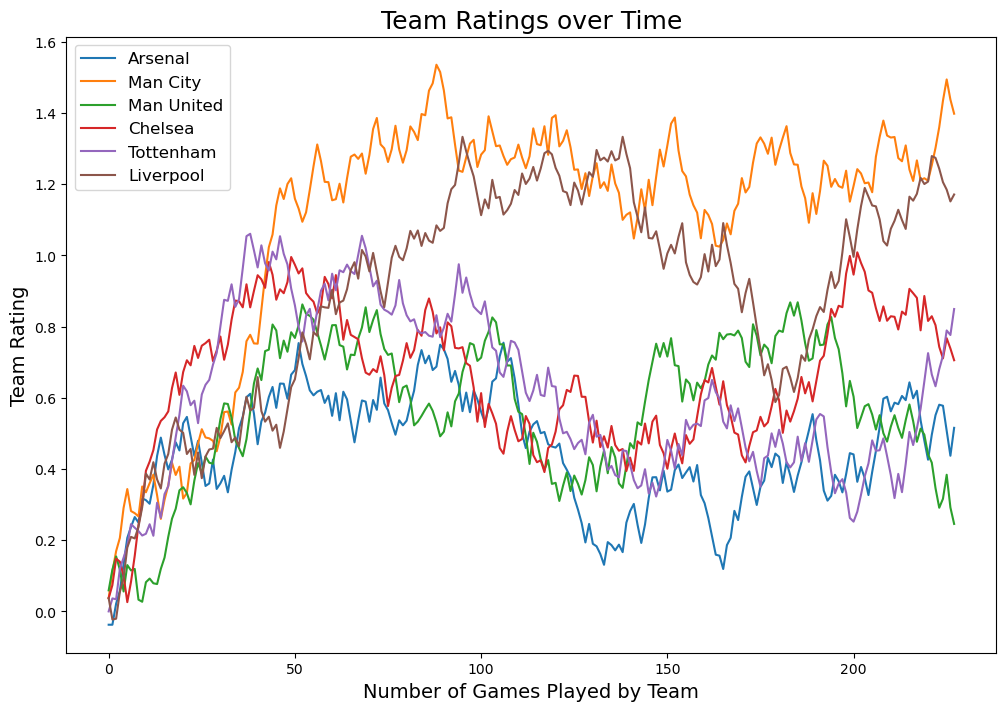

In [17]:
# plot ratings over time for big six in england

plt.figure(figsize=(12, 8))
df_ratings = pd.DataFrame(games_with_ratings)
teams = ["Arsenal", "Man City", "Man United", "Chelsea", "Tottenham", "Liverpool"]

for team in teams:
    per_team = df_ratings.loc[df_ratings["team"] == team].copy()
    per_team['match_number'] = range(len(per_team))
    plt.plot(per_team['match_number'], (per_team["home_rating"] + per_team["away_rating"]) / 2, label=team)

plt.xlabel('Number of Games Played by Team', fontsize=14)
plt.ylabel('Team Rating', fontsize=14)
plt.title('Team Ratings over Time', fontsize=18)
plt.legend(fontsize='large')

plt.savefig("../images/ratings_over_time_prem.png", dpi=300)

;

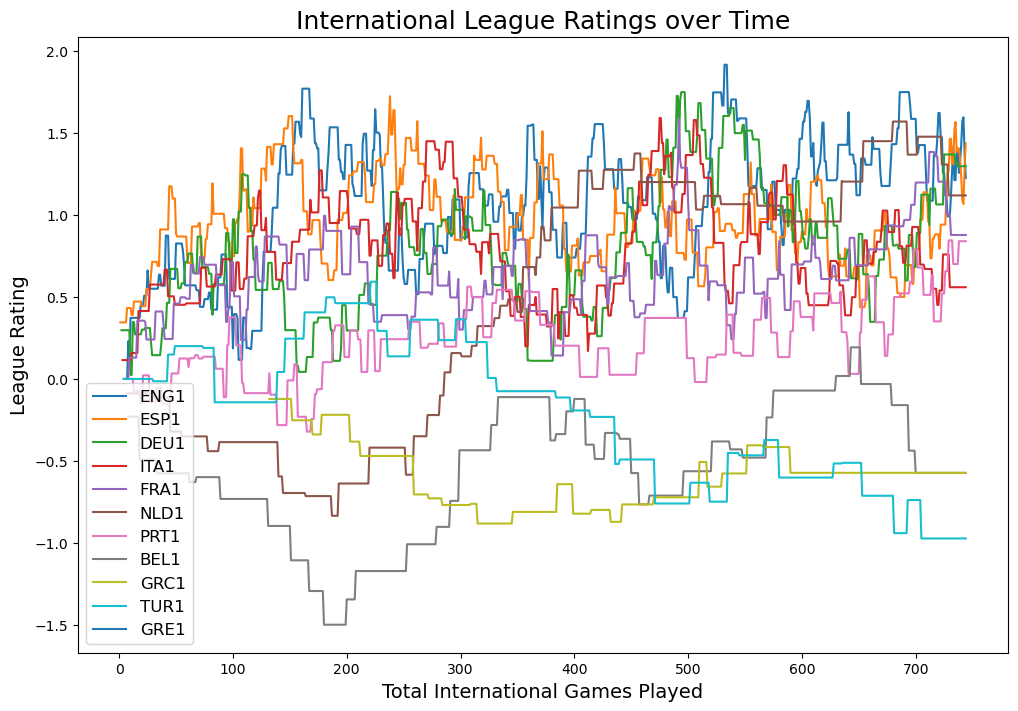

In [18]:
# plot league ratings over time

plt.figure(figsize=(12, 8))

df_ratings = pd.DataFrame(games_with_ratings_league)
all_game_counters = np.arange(df_ratings['game_counter'].max() + 1)
df_all = pd.DataFrame({'game_counter': all_game_counters})

leagues = ["ENG1", "ESP1", "DEU1", "ITA1", "FRA1", "NLD1", "PRT1", "BEL1", "GRC1", "TUR1", "GRE1"]

for league in leagues:
    per_league = df_ratings.loc[df_ratings["league"] == league]
    df_league = pd.merge(df_all, per_league[['game_counter', 'home_rating', 'away_rating']], on='game_counter', how='left')
    df_league[['home_rating', 'away_rating']] = df_league[['home_rating', 'away_rating']].fillna(method='ffill')
    plt.plot(df_league['game_counter'], (df_league["home_rating"] + df_league["away_rating"]) / 2, label=league)

plt.xlabel('Total International Games Played', fontsize=14)
plt.ylabel('League Rating', fontsize=14)
plt.title('International League Ratings over Time', fontsize=18)
plt.legend(fontsize='large')

ymin, ymax = plt.ylim()
plt.ylim(ymin*1, ymax*1)
         
plt.savefig("../images/ratings_over_time_leagues.png", dpi=300)



5813


''

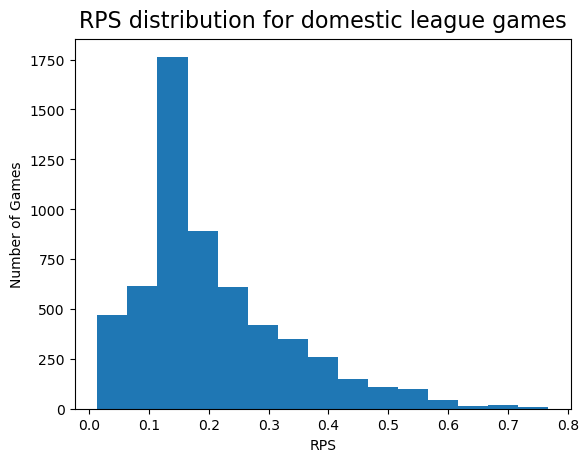

In [19]:
# plot rps distribution for domestic league games

plt.annotate("RPS distribution for domestic league games", (0.5, 1.05), xycoords='axes fraction', ha='center', va='center', size=16)
plt.hist(all_rps, bins=15)
plt.xlabel('RPS')
plt.ylabel('Number of Games')
plt.grid(False)

plt.savefig("../images/rps_distribution_dom.png", dpi=300)


# print amount of rps entries in all_rps
print(len(all_rps))



"""
for team, team_ratings in ratings.items():
    print(f"Team: {team}")
    print(f"Background Rating Home: {team_ratings['brH']}")
    print(f"Background Rating Away: {team_ratings['brA']}")
    print(f"Continuous Over/Underperformances: {team_ratings['continuous_overunderperformances']}")
    print()
"""
;

125


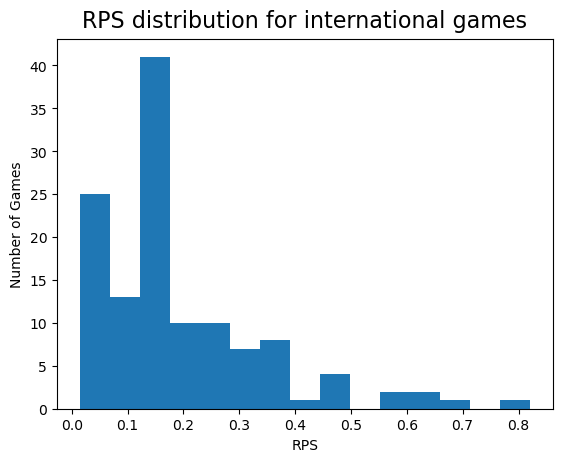

In [20]:
# Plot RPS distribution for international games

plt.annotate("RPS distribution for international games", (0.5, 1.05), xycoords='axes fraction', ha='center', va='center', size=16)
plt.hist(int_rps, bins=15)
plt.xlabel('RPS')
plt.ylabel('Number of Games')
plt.grid(False)
plt.savefig("../images/rps_distribution_int.png", dpi=300)

# print amount of rps entries in all_rps
print(len(int_rps))


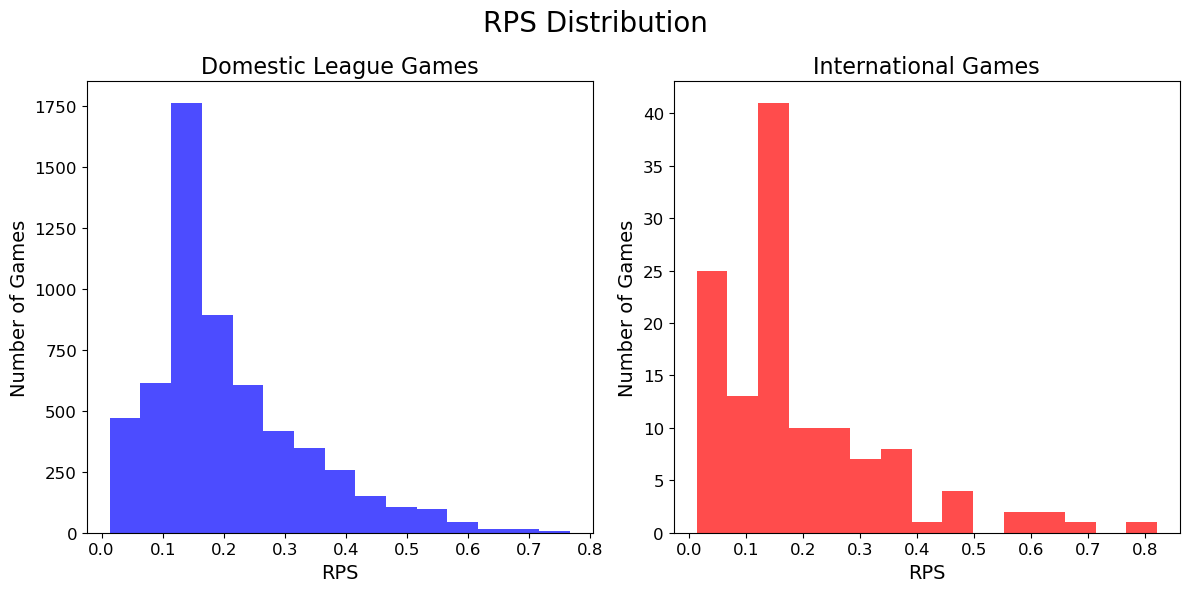

In [21]:
# combine rps distribution plots

fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

axs[0].hist(all_rps, bins=15, color='b', alpha=0.7)
axs[0].set_title('Domestic League Games', fontsize=16)
axs[0].set_xlabel('RPS', fontsize=14)
axs[0].set_ylabel('Number of Games', fontsize=14)
axs[0].grid(False)
axs[0].tick_params(axis='both', which='major', labelsize=12)

axs[1].hist(int_rps, bins=15, color='r', alpha=0.7)
axs[1].set_title('International Games', fontsize=16)
axs[1].set_xlabel('RPS', fontsize=14)
axs[1].set_ylabel('Number of Games', fontsize=14)
axs[1].grid(False)
axs[1].tick_params(axis='both', which='major', labelsize=12)

plt.suptitle('RPS Distribution', size=20)
plt.savefig("../images/rps_distribution_combined.png", dpi=300)

plt.show()




In [ ]:
# Gridsearch on lambda and gamma for teams

# Define the learning rates
rates = {
    'lambda': 0.043,
    'gamma': 0.98,
    'delta': 2.5,
    'phi': 1,
    'mu': 0.0,
    'rho': 0.9,
    'sigma': 0.7,
    'alpha': 99,
    'ind_threshold': 6000,
    'lambda2': 0.14,
    'gamma2': 0.96,
}


# Define a parameter grid with the ranges for your parameters
param_grid = {
    'lambda': np.linspace(0.04, 0.042, 3),
    'gamma': np.linspace(0.95, 0.97, 3)

}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable
best_score = float('inf')  # assuming lower scores are better

# Create an empty list to store the results
gs_results = []

# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    # Update the rates dictionary
    rates.update(params)
    
    ratings, league_ratings = initialize_ratings(df_results, df_fixtures,df_int_results, df_int_fixtures)
    
    # Re-train model with the new parameters
    ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)

    df_train = pd.DataFrame(training_games)
    #df_train.to_csv("../data/train232.csv", index=False)
    model = train_model(df_train)
    
    all_rps = []
    
    for competition in df_fixtures['Div'].unique():
        competition_fixtures = df_fixtures[df_fixtures['Div'] == competition]
        competition_rps, league_tables = predict_outcomes(competition_fixtures, ratings, league_ratings, rates, model)
        all_rps.extend(competition_rps)  # extend the list with rps scores from the current competition

    # Now you can calculate the mean RPS across all competitions
    mean_rps = np.mean(all_rps)

    score = mean_rps
    

    # Store the current results
    gs_results.append({
        'lambda': rates['lambda'],
        'gamma': rates['gamma'],
        'score': score,
    })
    
    print(f"Lambda: {rates['lambda']}, Gamma: {rates['gamma']}, Score: {score}")



In [ ]:
# Sort the results based on the score output top x; turn into dataframe
top_5_combinations = sorted(gs_results, key=lambda x: x['score'])[:10]

print("Top 5 combinations:")
for combo in top_5_combinations:
    print(f"Lambda: {combo['lambda']}, Gamma: {combo['gamma']}, Score: {combo['score']}")

# Convert the gs_results to a DataFrame and plot them

df_gs_results = pd.DataFrame(gs_results)
#to csv
df_gs_results.to_csv("../data/gs_resultslamgam_precise.csv", index=False)



In [ ]:
# plot gridsearch on lambda and gamma for teams

df_gs_results = pd.read_csv("../data/gs_resultslamgam_full_range.csv")

# Define grid of x, y values
lambda_range = np.linspace(0.01, 0.1, num=1000)
gamma_range = np.linspace(0.1, 1.0, num=1000)
lambda_grid, gamma_grid = np.meshgrid(lambda_range, gamma_range)

# Interpolate z values for this grid
rps_grid = griddata((df_gs_results['lambda'], df_gs_results['gamma']), df_gs_results['score'], (lambda_grid, gamma_grid), method='cubic')

# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(lambda_grid, gamma_grid, rps_grid, cmap='RdYlGn_r', edgecolor='none')
ax.set_xlabel(r'$\lambda_{\mathcal{T}}$')
ax.set_ylabel(r'$\gamma_{\mathcal{T}}$')
ax.set_zlabel('RPS Score', fontsize=10, labelpad=5)
ax.invert_zaxis()  # To make lower scores appear higher
#fig.colorbar(surf)
plt.savefig("../images/3d_plot_new_lg.png", dpi=300)
plt.show()

;

In [ ]:
# Gridsearch on lambda2 and gamma2 for leagues

# Define the learning rates
rates = {
    'lambda': 0.042,
    'gamma': 0.97,
    'delta': 2.5,
    'phi': 1,
    'mu': 0.0,
    'rho': 0.75,
    'sigma': 0.75,
    'alpha': 99,
    'ind_threshold': 6000,
    'lambda2': 0.14,
    'gamma2': 0.96,

}


# Define a parameter grid with the ranges for your parameters
param_grid = {
    'lambda2': np.linspace(0.11, 0.15, 5),
    'gamma2': np.linspace(0.94, 0.96, 5)

}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable
best_score = float('inf')  # assuming lower scores are better

# Create an empty list to store the results
gs_results2 = []

ratings, league_ratings = initialize_ratings(df_results, df_fixtures,df_int_results, df_int_fixtures)

ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)

_, _ = predict_outcomes(df_fixtures, ratings, league_ratings, rates, model)

df_train = pd.DataFrame(training_games)
#df_train.to_csv("../data/train232.csv", index=False)
model = train_model(df_train)


# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    # Update the rates dictionary
    rates.update(params)
    
    _, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
    
    # Re-train model with the new parameters
    league_ratings = update_league_ratings_multiple_games(df_int_results, league_ratings, rates)
  
    
        
    int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)
   
    # Now you can calculate the mean RPS across all competitions
    mean_rps = np.mean(int_rps)

    score = mean_rps
    
    # Store the current results
    gs_results2.append({
        'lambda2': rates['lambda2'],
        'gamma2': rates['gamma2'],
        'score': score,
    })
    
    print(f"Lambda2: {rates['lambda2']}, Gamma2: {rates['gamma2']}, Score: {score}")



In [ ]:
# Sort the results based on the score for lambda 2 and gamma 2 and turn into dataframe
top_combinations = sorted(gs_results2, key=lambda x: x['score'])[:10]

print("Top 5 combinations:")
for combo in top_combinations:
    print(f"Lambda2: {combo['lambda2']}, Gamma2: {combo['gamma2']}, Score: {combo['score']}")

# Convert the gs_results to a DataFrame and plot them

df_gs_results2 = pd.DataFrame(gs_results2)
#to csv
df_gs_results2.to_csv("../data/gs_resultslam2gam2_fullrange.csv", index=False)



In [ ]:
#plot gridsearch on lambda2 and gamma2 for leagues

df_gs_results2 = pd.read_csv("../data/gs_resultslam2gam2_fullrange.csv")

# Define grid of x, y values
lambda2_range = np.linspace(0.02, 0.2, num=100)
gamma2_range = np.linspace(0.5, 1.0, num=100)
lambda2_grid, gamma2_grid = np.meshgrid(lambda2_range, gamma2_range)

# Interpolate z values for this grid
rps2_grid = griddata((df_gs_results2['lambda2'], df_gs_results2['gamma2']), df_gs_results2['score'], (lambda2_grid, gamma2_grid), method='cubic')

# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(lambda2_grid, gamma2_grid, rps2_grid, cmap='RdYlGn_r', edgecolor='none')
ax.set_xlabel(r'$\lambda_{\mathcal{L}}$')
ax.set_ylabel(r'$\gamma_{\mathcal{L}}$')
ax.set_zlabel('RPS Score', fontsize=10, labelpad=5)
ax.invert_zaxis()  # To make lower scores appear higher
#fig.colorbar(surf)
plt.savefig("../images/3d_plot_new_l2g2.png", dpi=300)
plt.show()


In [ ]:
# Gridsearch on sigma and rho

# Define the learning rates
rates = {
    'lambda': 0.042,
    'gamma': 0.97,
    'delta': 2.5,
    'phi': 1,
    'mu': 0.0,
    'rho': 0.9,
    'sigma': 0.7,
    'alpha': 99,
    'ind_threshold': 6000,
    'lambda2': 0.13,
    'gamma2': 0.96,

}


# Define a parameter grid with the ranges for your parameters
param_grid = {
    'rho': np.linspace(0.8, 0.9, 11),
    'sigma': np.linspace(0.65, 0.75, 11)

}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable
best_score = float('inf')  # assuming lower scores are better

# Create an empty list to store the results
gs_results3 = []

ratings, league_ratings = initialize_ratings(df_results, df_fixtures,df_int_results, df_int_fixtures)

ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)

_, _ = predict_outcomes(df_fixtures, ratings, league_ratings, rates, model)

df_train = pd.DataFrame(training_games)
#df_train.to_csv("../data/train232.csv", index=False)
model = train_model(df_train)


# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    # Update the rates dictionary
    rates.update(params)
    
    _, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
    
    # Re-train model with the new parameters
    league_ratings = update_league_ratings_multiple_games(df_int_results, league_ratings, rates)
  
    
        
    int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)
   
    # Now you can calculate the mean RPS across all competitions
    mean_rps = np.mean(int_rps)

    score = mean_rps
    
    # Store the current results
    gs_results3.append({
        'rho': rates['rho'],
        'sigma': rates['sigma'],
        'score': score,
    })
    
    print(f"rho: {rates['rho']}, sigma: {rates['sigma']}, Score: {score}")


In [ ]:
# Sort the results based on the score and get the top x; turn into dataframe (sigma and rho)
top_combinations = sorted(gs_results3, key=lambda x: x['score'])[:10]

print("Top combinations:")
for combo in top_combinations:
    print(f"rho: {combo['rho']}, sigma: {combo['sigma']}, Score: {combo['score']}")

# Convert the gs_results to a DataFrame and plot them

df_gs_results3 = pd.DataFrame(gs_results3)
#to csv
df_gs_results3.to_csv("../data/gs_resultsrhosig.csv", index=False)


In [ ]:
# plot gridsearch on sigma and rho 

df_gs_results3 = pd.read_csv("../data/gs_resultsrhosig.csv")

# Define grid of x, y values
rho_range = np.linspace(0, 1.5, num=100)
sigma_range = np.linspace(0, 1.5, num=100)
rho_grid, sigma_grid = np.meshgrid(rho_range, sigma_range)

# Interpolate z values for this grid
rps3_grid = griddata((df_gs_results3['rho'], df_gs_results3['sigma']), df_gs_results3['score'], (rho_grid, sigma_grid), method='cubic')

# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(rho_grid, sigma_grid, rps3_grid, cmap='RdYlGn_r', edgecolor='none')
ax.set_xlabel(r'$\rho}$')
ax.set_ylabel(r'$\sigma}$')
ax.set_zlabel('RPS Score', fontsize=10, labelpad=5)
ax.invert_zaxis()  # To make lower scores appear higher
#fig.colorbar(surf)
plt.savefig("../images/3d_plot_new_rs.png", dpi=300)
plt.show()

In [ ]:
# find optimal threshold


# Define range for int_threshold
thresholds = np.arange(0, 34000, 2000)  

# Initialize the best_score variable
best_score = float('inf')  

# Create an empty list to store the results
optimization_results = []

for threshold in tqdm.tqdm(thresholds):
    # Update rates with the current threshold
    rates['int_threshold'] = threshold

    ratings, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
        
    # Train and evaluate your model with the current threshold
    ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)
        
    df_train = pd.DataFrame(training_games)
    #df_train.to_csv("../data/train.csv", index=False)
    model = train_model(df_train)

    all_rps, league_tables = predict_outcomes(df_fixtures, ratings, league_ratings, rates, model)
    score = np.mean(all_rps)

    # If the current score is better than the best_score, update best_score
    if score < best_score:
        best_score = score
        best_threshold = threshold

    # Store the current score and threshold
    optimization_results.append({
        'int_threshold': threshold,
        'score': score,
    })
        
    print(f"Threshold: {threshold}, Score: {score}")

# Convert the results to a DataFrame and sort by score
df_optimization_results = pd.DataFrame(optimization_results).sort_values(by='score', ascending=True)

# Display the top 5 combinations of the threshold and their score
print(df_optimization_results.head(10))


print(f"Best int_threshold: {best_threshold}")
print(f"Best score: {best_score}")


In [ ]:
# grid search on provisional ratings

rates = {
    'lambda': 0.04,
    'gamma': 0.96,
    'delta': 1,
    'phi': 1,
    'mu': 0,
    'rho': 0.93,
    'sigma': 0.6,
    'alpha': 99,
    'ind_threshold': 0,
    'lambda2': 0.15,
    'gamma2': 0.97,
}

# Train and predict with current_rates (and current_model if necessary)
ratings, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
    
# 3. Re-train model with the new parameters
ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)
    
    
df_train = pd.DataFrame(training_games)
#df_train.to_csv("../data/train232.csv", index=False)
current_model = train_model(df_train)

# 1. Define the parameter grid
param_grid = {
    'mu': np.linspace(0.0, 0.2, 3),  
    'phi': np.linspace(0, 2, 3), 
    'delta': np.linspace(1.5, 3.5, 3)  
}


# Initialize the best_score variable and best_params dictionary
best_score = float('inf')
best_params = {}

# Create an empty list to store the results
gs_results = []

# 2. Iterate over the parameter combinations
for params in tqdm.tqdm(ParameterGrid(param_grid)):
    # Extract rates from params and merge with the existing rates dictionary
    current_rates = rates.copy()
    current_rates.update(params)
    
    
    # Train and predict with current_rates (and current_model if necessary)
    ratings, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
    
    # 3. Re-train model with the new parameters
    ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, current_rates)
    
    # If your training method updates the model based on rates, you should train it here
    
    # Predict the probabilities of home win, draw and away win for the fixtures data
    all_rps = []
    for competition in df_fixtures['Div'].unique():
        competition_fixtures = df_fixtures[df_fixtures['Div'] == competition]
        competition_rps, _ = predict_outcomes(competition_fixtures, ratings, league_ratings, current_rates, model)
        all_rps.extend(competition_rps)  # extend the list with rps scores from the current competition
    
    score = np.mean(all_rps)
    

    # If the current score is better than the best_score, update best_score and best_params
    if score < best_score:
        best_score = score
        best_params = params

    # Store the current score and parameters
    gs_results.append({
        'mu': params['mu'],
        'phi': params['phi'],
        'delta': params['delta'],
        'score': score,
    })
    
#  Identify the best parameters based on the score
print(f'Best score: {best_score}')
print(f'Best params: {best_params}')

# Convert the gs_results to a DataFrame
df_gs_results = pd.DataFrame(gs_results)

# Sort the results by score and get the top 5
top_5_results = df_gs_results.sort_values(by='score', ascending=True).head(5)

print("Top 5 parameter combinations:")
print(top_5_results)


In [ ]:
# Lists to hold the parameter 'rho', 'sigma' and the corresponding RPS values
parameter_values = []
rps_values = []

# Grid of potential values for rho and sigma
potential_rho_values = np.linspace(0.75, 1.0, num=26)
potential_sigma_values = np.linspace(0.5, 0.7, num=21)

# Iterate over potential rho and sigma values
for rho in potential_rho_values:
    for sigma in potential_sigma_values:
        rates['rho'] = rho
        rates['sigma'] = sigma
        
        # Obtain the RPS for the current value of rho and sigma
        int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)

        # Compute the average RPS
        avg_rps = np.mean(int_rps)

        # Add current result to the lists
        parameter_values.append((rho, sigma))
        rps_values.append(avg_rps)

# Identify top 5 parameter combinations
top_indices = np.argsort(rps_values)[:5]  # gets the indices of the 5 lowest RPS scores
top_parameters = [parameter_values[i] for i in top_indices]
top_rps_values = [rps_values[i] for i in top_indices]

# Print top 5 parameter combinations
for i in range(5):
    print(f"Rank {i+1}, Parameters (rho, sigma): {top_parameters[i]}, RPS Score: {top_rps_values[i]}")


In [ ]:
# alternative function to train model based on other machine learning methods

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def train_model2(df_train):
    # Feature Selection
    X = df_train["rating_difference"].values.reshape(-1, 1)
    y = df_train['FTR']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    # Model Selection and Parameter Tuning
    #model = LogisticRegression(solver="saga", penalty="l2", tol=1e-3, C=0.1)
    #model = RandomForestClassifier(n_estimators=100, random_state=42)
    model = GradientBoostingClassifier(n_estimators=100)
    #model = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(5, 2), max_iter=1000)
    
    # Fit the model with the training data
    model.fit(X_train, y_train)
    
    # Save the model and label encoder here
    joblib.dump(model, '../Models/model.pkl')
    
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'Model accuracy: {accuracy*100:.2f}%')
    print(f'Model precision: {precision*100:.2f}%')
    print(f'Model recall: {recall*100:.2f}%')
    print(f'Model F1-score: {f1*100:.2f}%')
    
    return model

    
;

In [ ]:
# alternative train model function with cross validation

from sklearn.model_selection import cross_val_score

def train_model(df_train):
    
    # Feature Selection
    X = df_train["rating_difference"].values.reshape(-1, 1)
    y = df_train['FTR']
    
    # Model Selection and Parameter Tuning
    model = LogisticRegression(solver="saga", penalty="l2")
    
    # Cross-Validation
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f'Cross-Validation Accuracy Scores: {scores}')
    print(f'Mean Accuracy: {scores.mean()*100:.2f}%')
    print(f'Standard Deviation: {scores.std()*100:.2f}%')
    
    # Fit the model with all the data
    model.fit(X, y)
    
    # Save the model and label encoder here
    joblib.dump(model, '../Models/model.pkl')
    
    return model


In [ ]:
# previously used function to map teams to leagues; outdated

def create_team_to_league_mapping(df_results, df_fixtures, df_int):
    team_to_league = {}
    rest_teams = set() 

    def get_league_level(division):
        # Extracting the integer part from the division
        integer_part = ''.join(filter(str.isdigit, division))
        return int(integer_part)


    # Iterate through the results and fixtures dataframes and map teams to their leagues
    for df in [df_results, df_fixtures]:
        for index, row in df.iterrows():
            for team in [row['HomeTeam'], row['AwayTeam']]:
                current_div = row['Div']
                current_level = get_league_level(current_div)

                # If the team is not yet in the dictionary, or if the current league is higher, update the entry
                if team not in team_to_league or current_level < get_league_level(team_to_league[team]):
                    team_to_league[team] = current_div

    # Now process df_int
    for index, row in df_int.iterrows():
        for team in [row['HomeTeam'], row['AwayTeam']]:
            if team not in team_to_league:
                # If the team is not found in the other dataframes, assign it to 'REST'
                team_to_league[team] = 'REST'
                rest_teams.add(team)

    return team_to_league, rest_teams

In [ ]:
# previously used to intialize ratings for teams that are not in the results data; outdated

def initialize_rest_ratings(rest_teams):
    rest_ratings = {}
    for team in rest_teams:
        rest_ratings[team] = {
            'REST': {
                'brH': 0.0,
                'brA': 0.0,
                'continuous_overunderperformances': 0
            }
        }
    return rest_ratings

In [ ]:
# previously used to update league tables, not in use anymore; outdated

def update_league_table(league_table, HomeTeam, AwayTeam, home_win_prob, draw_prob, away_win_prob):

    # Calculate points based on probabilities
    home_points = home_win_prob * 3 + draw_prob * 1
    away_points = away_win_prob * 3 + draw_prob * 1

    # Home team update
    if HomeTeam in league_table['team'].values:
        league_table.loc[league_table['team'] == HomeTeam, 'games_played'] += 1
        league_table.loc[league_table['team'] == HomeTeam, 'points'] += home_points
    else:
        df_home = pd.DataFrame({'team': [HomeTeam], 'games_played': [1], 'points': [home_points]})
        league_table = pd.concat([league_table, df_home], ignore_index=True)

    # Away team update
    if AwayTeam in league_table['team'].values:
        league_table.loc[league_table['team'] == AwayTeam, 'games_played'] += 1
        league_table.loc[league_table['team'] == AwayTeam, 'points'] += away_points
    else:
        df_away = pd.DataFrame({'team': [AwayTeam], 'games_played': [1], 'points': [away_points]})
        league_table = pd.concat([league_table, df_away], ignore_index=True)

    return league_table

In [ ]:
# Print league tables; outdated
for competition, league_table in league_tables.items():
    print(f"League table for {competition}:")
    league_table_df = league_table.copy()  # creating a copy to avoid modifying the original data
    league_table_df.index = league_table_df.index + 1
    print(league_table_df)
    league_table_df.index = league_table_df.index - 1

;

In [ ]:
# combined gridsearch for int rating; outdated

# Define the learning rates
rates = {
    'lambda': 0.043,
    'gamma': 0.98,
    'delta': 2.5,
    'phi': 1,
    'mu': 0.0,
    'rho': 0.9,
    'sigma': 0.7,
    'tau': 0.001,
    'ind_threshold': 6000,
    'lambda2': 0.14,
    'gamma2': 0.96,
    'x': 1.3,
    'y' : 1.0,
    'a' : -1.625,
    'b' : 0.75
}


# Define a parameter grid with the ranges for your parameters
param_grid = {
    'lambda2': np.linspace(0.1, 0.2, 11),
    'gamma2': np.linspace(0.94, 0.98, 5),
    'rho': np.linspace(0.8, 1.0, 5),
    'sigma': np.linspace(0.5, 0.9, 5)

}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable
best_score = float('inf')  # assuming lower scores are better

# Create an empty list to store the results
gs_results4 = []

ratings, league_ratings = initialize_ratings(df_results, df_fixtures,df_int_results, df_int_fixtures)

ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)

_, _ = predict_outcomes(df_fixtures, ratings, league_ratings, rates, model)

df_train = pd.DataFrame(training_games)
#df_train.to_csv("../data/train232.csv", index=False)
model = train_model(df_train)


# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    # Update the rates dictionary
    rates.update(params)
    
    _, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
    
    # Re-train model with the new parameters
    league_ratings = update_league_ratings_multiple_games(df_int_results, league_ratings, rates)
  
    
        
    int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)
   
    # Now you can calculate the mean RPS across all competitions
    mean_rps = np.mean(int_rps)

    score = mean_rps
    
    # Store the current results
    gs_results4.append({
        'lambda2': rates['lambda2'],
        'gamma2': rates['gamma2'],
        'rho': rates['rho'],
        'sigma': rates['sigma'],
        'score': score,
    })
    
    print(f"lambda2: {rates['lambda2']}, gamma2: {rates['gamma2']}, rho: {rates['rho']}, sigma: {rates['sigma']}, Score: {score}")


In [ ]:
# turn gridsearch results for lambda2, gamma2, rho and sigma into dataframe; outdated

# Sort the results based on the score and get the top 5
top_combinations = sorted(gs_results4, key=lambda x: x['score'])[:10]

print("Top combinations:")
for combo in top_combinations:
    print(f"lambda2: {combo['lambda2']}, gamma2: {combo['gamma2']}, rho: {combo['rho']}, sigma: {combo['sigma']}, Score: {combo['score']}")

# Convert the gs_results to a DataFrame and plot them

df_gs_results4 = pd.DataFrame(gs_results4)
#to csv
df_gs_results4.to_csv("../data/gs_results_lam2gam2rhosig.csv", index=False)

In [ ]:
# Create 2D plot with colormap for girdsearch on lambda and gamma; outdated

plt.figure(figsize=(10, 10))  # Adjust figsize to your preference to make the plot square
plt.title('Grid Search Scores')

cmap_reversed = plt.cm.get_cmap('RdYlGn_r')  # Reversed Red-Yellow-Green colormap

# Here we store the image object returned by imshow
im = plt.imshow(rps_grid, interpolation='nearest', cmap=cmap_reversed,
           extent=(param_grid['lambda'].min(), param_grid['lambda'].max(), param_grid['gamma'].min(), param_grid['gamma'].max()), origin='lower')

# We use the stored image object for the colorbar
plt.colorbar(im, cmap=cmap_reversed)

plt.axis('square')  # This will enforce a square aspect ratio

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Lambda")
plt.ylabel("Gamma")
plt.savefig("../images/2d_plot_heat_new.png", dpi=300)
plt.show()

# Convert grid search results into a pivot table for plotting
pivot_table = df_gs_results.pivot('lambda', 'gamma', 'score')

# Create contour plot
plt.figure(figsize=(10,7))
contour_plot = plt.contourf(pivot_table.columns, pivot_table.index, pivot_table.values, cmap='RdYlGn_r', levels=100)
plt.title('Grid Search RPS Scores')
plt.xlabel('Lambda')
plt.ylabel('Gamma')

# Add a colorbar
cbar = plt.colorbar(contour_plot)
cbar.ax.set_ylabel('RPS Score')

plt.savefig("../images/2d_plot_contour_gs232.png", dpi=300)
plt.show()